SKILL LCA 3 (MICRO PROJECT)

So the given dataset deals with the network packet tracing and possible attacks during the packet transfer process. I will be performing a multi_output classification at the end of the project. the project involves several processes like merging the data cleaning the data sampling and re-sampling the data finding the apptoprite features for prediction and training the model to achieve accurate predictions. 

firstly we will import all the lybries necessary in one cell block itself.

In [1]:
import warnings
from sklearn.metrics import f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

     

Adding the below snippet of code so that any warnings in the outputs will not be seen.

In [2]:
warnings.filterwarnings("ignore")

Merging the dataset.
as we know the dataset was spilt in 4 files here we will import all thhe four files and merge them into a single dataframe.

In [ ]:
# Paths to your datasets
csv_files = [
    r"C:\Users\sabni\Desktop\SKILL LCA\UNSW_2018_IoT_Botnet_Full5pc_1.csv",
    r"C:\Users\sabni\Desktop\SKILL LCA\UNSW_2018_IoT_Botnet_Full5pc_2.csv",
    r"C:\Users\sabni\Desktop\SKILL LCA\UNSW_2018_IoT_Botnet_Full5pc_3.csv",
    r"C:\Users\sabni\Desktop\SKILL LCA\UNSW_2018_IoT_Botnet_Full5pc_4.csv"
]

merged_df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

merged_df.to_csv('merged_file.csv', index=False)
print("Number of rows:", len(merged_df))

Number of rows: 3668522


Here we will be visualizing the data dirstribution between the three target variables that i am using.


 Frequency of values in 'attack' column:
attack
1    3668045
0        477
Name: count, dtype: int64


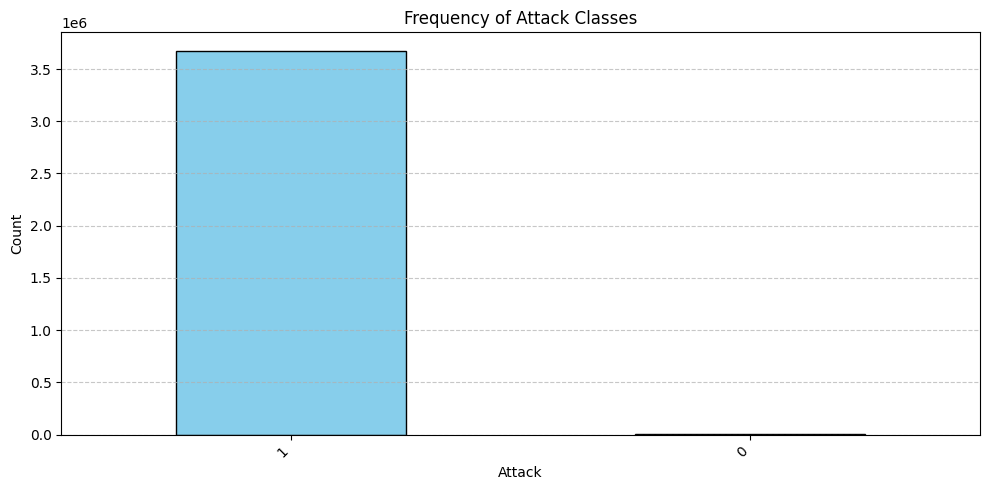


 Frequency of values in 'category' column:
category
DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: count, dtype: int64


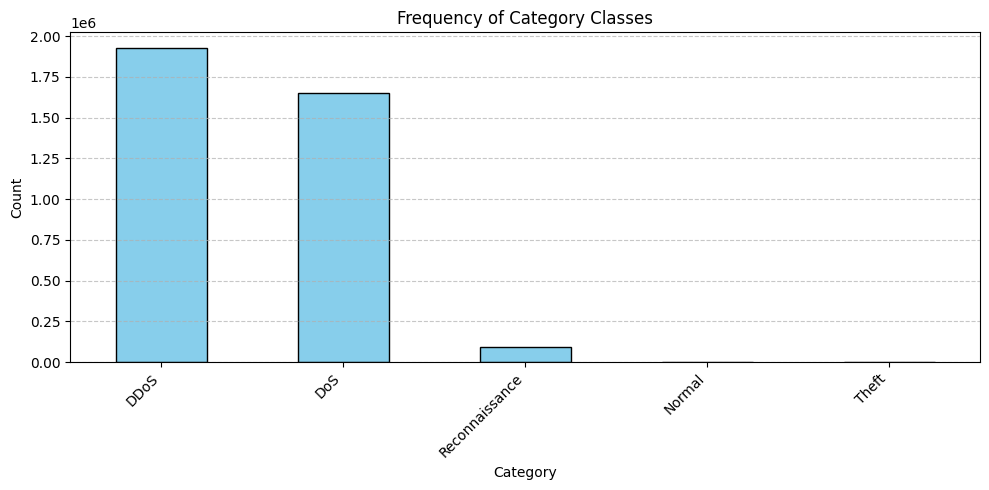


 Frequency of values in 'subcategory' column:
subcategory
UDP                  1981230
TCP                  1593180
Service_Scan           73168
OS_Fingerprint         17914
HTTP                    2474
Normal                   477
Keylogging                73
Data_Exfiltration          6
Name: count, dtype: int64


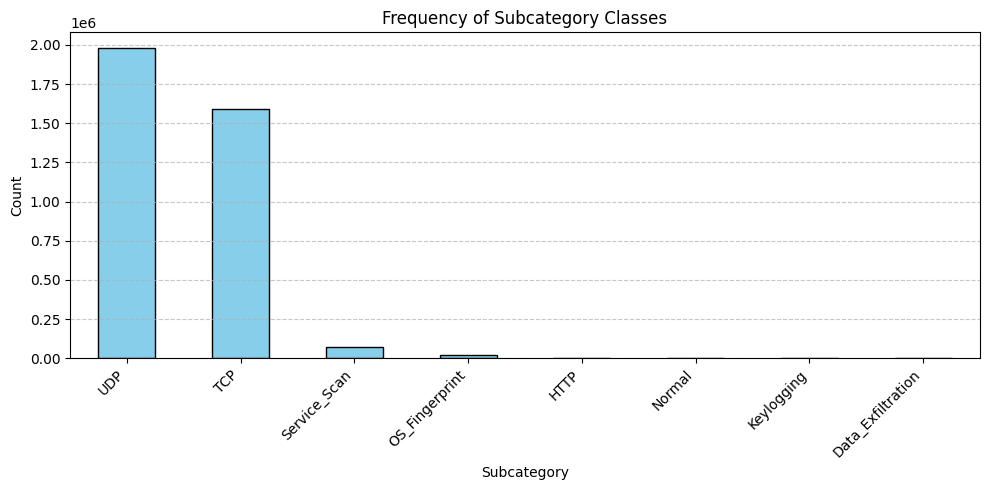

In [5]:
# Read the merged CSV (ensure correct encoding for special characters)
df = pd.read_csv(r"C:\Users\sabni\Documents\SKILL\__pycache__\merged_file.csv")

# Columns to analyze
columns = ['attack', 'category', 'subcategory']

# Loop through each column and plot frequency
for col in columns:
    if col in df.columns:
        freq = df[col].value_counts()

        print(f"\n Frequency of values in '{col}' column:")
        print(freq)

        # Plotting histogram/bar chart
        plt.figure(figsize=(10, 5))
        freq.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Frequency of {col.capitalize()} Classes")
        plt.xlabel(f"{col.capitalize()}")
        plt.ylabel("Count")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
    else:
        print(f" Column '{col}' not found in the dataset.")


i am currently using the subcategory as my target as it is derives from the other columns.
here i will remove the rows with the class as Keylogging and Data_Exfiltration as they ahve very few observations each.

In [6]:

# Conditions for deletion
condition_to_delete = (
    (df['category'] == 'Theft') &
    (df['subcategory'].isin(['Keylogging', 'Data_Exfiltration'])) &
    (df['attack'] != 'Normal')
)

# Show how many rows will be deleted
print(" Rows to delete:", condition_to_delete.sum())

# Drop those rows
df_cleaned = df[~condition_to_delete]

df_cleaned.head()

print("Number of rows:", len(df_cleaned))


 Rows to delete: 79
Number of rows: 3668443


no we will bw converting the data inot a operable datasize of roughly 100000 rows wile performing manual sampling so that the class dristeibution is not hampred now.

In [7]:


# All rows where subcategory is 'HTTP' or 'Normal'
http_rows = df_cleaned[df_cleaned['subcategory'] == 'HTTP']
normal_rows = df_cleaned[df_cleaned['subcategory'] == 'Normal']

# Random samples from the other subcategories
os_fingerprint_sample = df_cleaned[df_cleaned['subcategory'] == 'OS_Fingerprint'].sample(n=12000, random_state=42)
service_scan_sample = df_cleaned[df_cleaned['subcategory'] == 'Service_Scan'].sample(n=25000, random_state=42)
tcp_sample = df_cleaned[df_cleaned['subcategory'] == 'TCP'].sample(n=30000, random_state=42)
udp_sample = df_cleaned[df_cleaned['subcategory'] == 'UDP'].sample(n=30000, random_state=42)

# Combine all into a new smaller dataframe
reduced_df = pd.concat([
    http_rows,
    normal_rows,
    os_fingerprint_sample,
    service_scan_sample,
    tcp_sample,
    udp_sample
], ignore_index=True)


print(" Reduced dataframe created with shape:", reduced_df.shape)
print(" Saved as 'reduced_dataset.csv' on Desktop.")


 Reduced dataframe created with shape: (99951, 46)
 Saved as 'reduced_dataset.csv' on Desktop.


Visualizing the new data dristribution of 100000 rows.


 Frequency of values in 'subcategory' column:
subcategory
TCP               30000
UDP               30000
Service_Scan      25000
OS_Fingerprint    12000
HTTP               2474
Normal              477
Name: count, dtype: int64


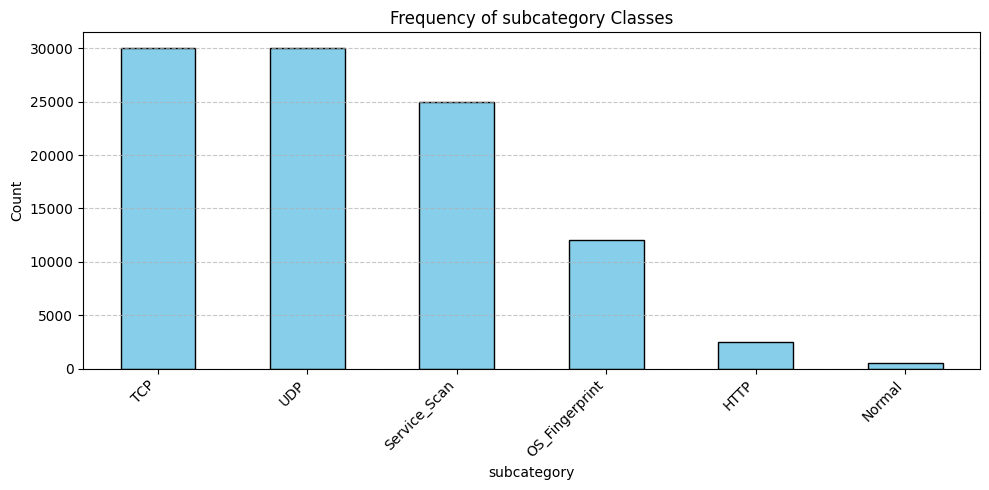

In [8]:
freq = reduced_df[col].value_counts()

print(f"\n Frequency of values in 'subcategory' column:")
print(freq)

# Plotting histogram/bar chart
plt.figure(figsize=(10, 5))
freq.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"Frequency of subcategory Classes")
plt.xlabel(f"subcategory")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

though the data is pretty muched cleaned we will still perform some data cleaning operations on the dataset just to be safe.

In [9]:


# Drop missing values
reduced_df.dropna(axis=0, inplace=True)

# Display info and basic stats
print("DataFrame Info:")
print(reduced_df.info())
print("\n\n\n\n")

print("Descriptive Statistics:")
print(reduced_df.describe())
print("\n\n\n\n")

# Check for null values
print("Any Null Values Present:")
print(reduced_df.isnull().any())
print("\n\n\n\n")

print("Sum of Null Values per Column:")
print(reduced_df.isnull().sum())
print("\n\n\n\n")

# Check for duplicates
print("Any Duplicated Rows:")
print(reduced_df.duplicated().any())
print("\n\n\n\n")

# Drop duplicates
reduced_df.drop_duplicates(inplace=True)



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99951 entries, 0 to 99950
Data columns (total 46 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   pkSeqID                           99951 non-null  int64  
 1   stime                             99951 non-null  float64
 2   flgs                              99951 non-null  object 
 3   flgs_number                       99951 non-null  int64  
 4   proto                             99951 non-null  object 
 5   proto_number                      99951 non-null  int64  
 6   saddr                             99951 non-null  object 
 7   sport                             99951 non-null  object 
 8   daddr                             99951 non-null  object 
 9   dport                             99951 non-null  object 
 10  pkts                              99951 non-null  int64  
 11  bytes                             99951 non-null  i

performing outlier detection and removal on a dataframe using statistical methods like IQR to identify and eliminate extreme values.
but as we can see in the output a lot of rows are being dropped hence i am not taking this into consideration for now.

In [10]:
# Use a copy to avoid modifying original data directly
df_no_outliers =reduced_df.copy()

# Select only numeric columns (excluding categorical targets like 'subcategory')
numeric_cols = df_no_outliers.select_dtypes(include='number').columns

# Loop through each numeric column and apply IQR filtering
for col in numeric_cols:
    Q1 = df_no_outliers[col].quantile(0.25)
    Q3 = df_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Keep only the rows that are not outliers in this feature
    df_no_outliers = df_no_outliers[
        (df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)
    ]

# View the resulting cleaned dataset
print(f"Original dataset shape: {reduced_df.shape}")
print(f"Dataset shape after removing outliers: {df_no_outliers.shape}")


Original dataset shape: (99951, 46)
Dataset shape after removing outliers: (25341, 46)


Here i will be dropping hree columns namely flags, proto and state as the dataset already has the encoded version of the categorical values.

In [11]:

# Drop the specified columns
df = reduced_df.drop(columns=['flgs', 'proto', 'state','pkSeqID'])
df.head()
df.to_csv('final.csv', index=False)

Lable encoding

performing lable encoding on all the categorical features in the dataset.

In [12]:

# Create a copy of the dataset to avoid modifying the original
df_encoded = df.copy()

# Initialize the LabelEncoder
le = LabelEncoder()

# Loop through each column and apply LabelEncoder to non-numeric columns
for col in df_encoded.columns:
    if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Check result
print(" All non-numeric columns encoded.")
print(df_encoded.dtypes)
print(df_encoded.head())


 All non-numeric columns encoded.
stime                               float64
flgs_number                           int64
proto_number                          int64
saddr                                 int64
sport                                 int64
daddr                                 int64
dport                                 int64
pkts                                  int64
bytes                                 int64
state_number                          int64
ltime                               float64
seq                                   int64
dur                                 float64
mean                                float64
stddev                              float64
sum                                 float64
min                                 float64
max                                 float64
spkts                                 int64
dpkts                                 int64
sbytes                                int64
dbytes                                int6

generating a heatmap showing the correlation of all the features with each other to better understand the relation of all the features.

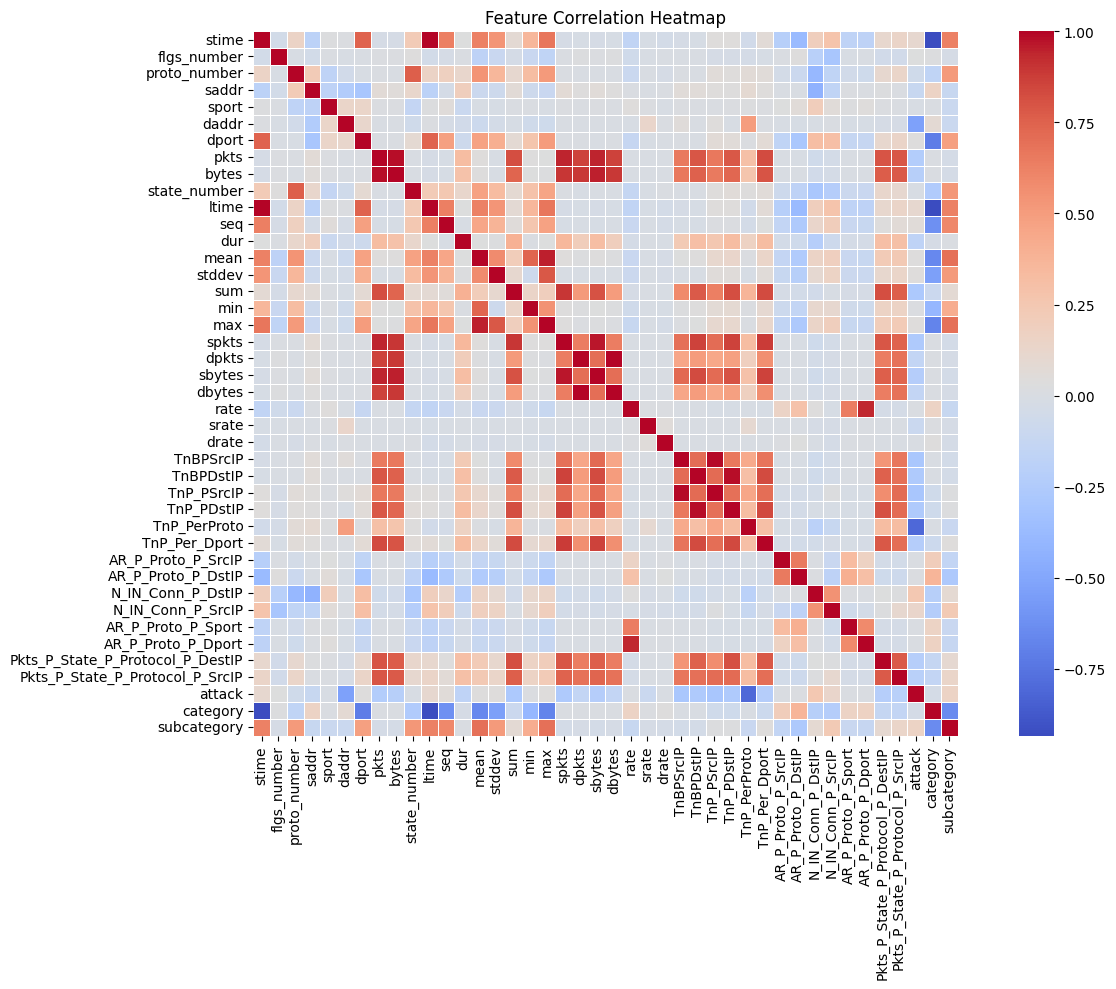

In [13]:
# Compute and plot the correlation matrix
plt.figure(figsize=(14, 10))
corr = df_encoded.corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, fmt='.2f', square=True, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


But since it is evident that hte heatmap although not perfect, it still provides valuable insights into the data.
for futher feature selection we will consider additional metrics and techniques to refine our dataset.

performing test train split on the data to for carrying out feature selection methods.

In [14]:
# Separate features and targets
X = df_encoded.drop(['attack', 'category', 'subcategory'], axis=1)
y = df_encoded[['attack', 'category', 'subcategory']]  # Multi-target as a DataFrame

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

targets = y_train.columns.tolist()


# Output the shapes
print("Training features shape:", X_train.shape)
print("Testing features shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)


Training features shape: (79960, 39)
Testing features shape: (19991, 39)
Training labels shape: (79960, 3)
Testing labels shape: (19991, 3)


FILTER METHODS

1. Mutual Information (a.k.a Mutual Gain)
What it does: Measures how much information one feature gives about the target.

Use case: Good for non-linear relationships.

Output: Score between 0 and 1 (higher = more informative).

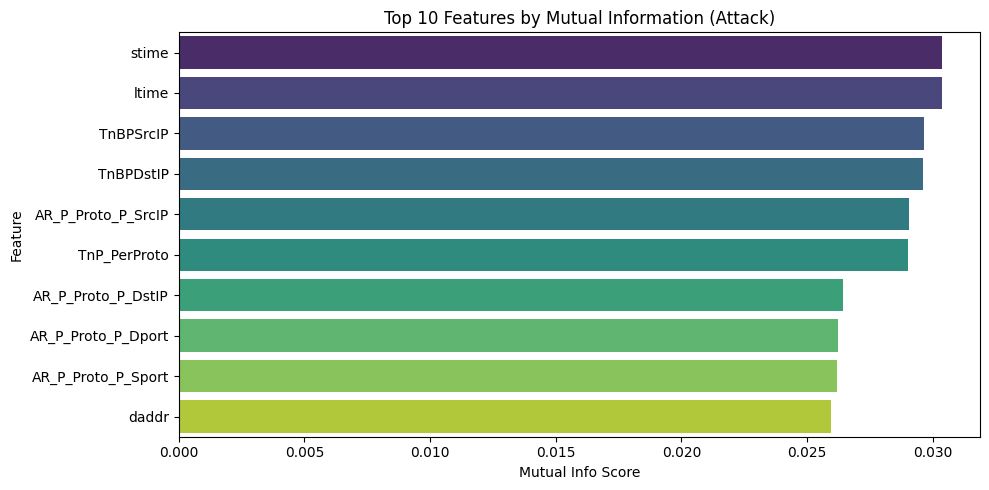

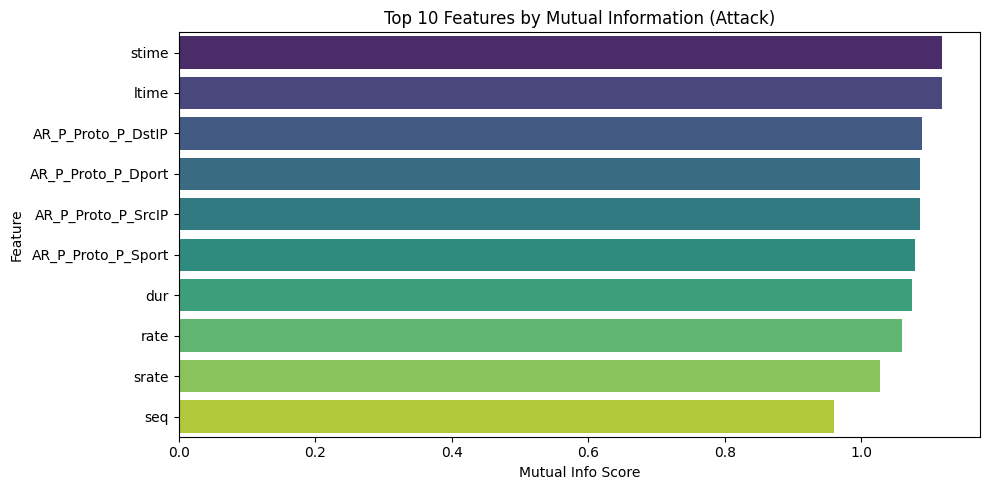

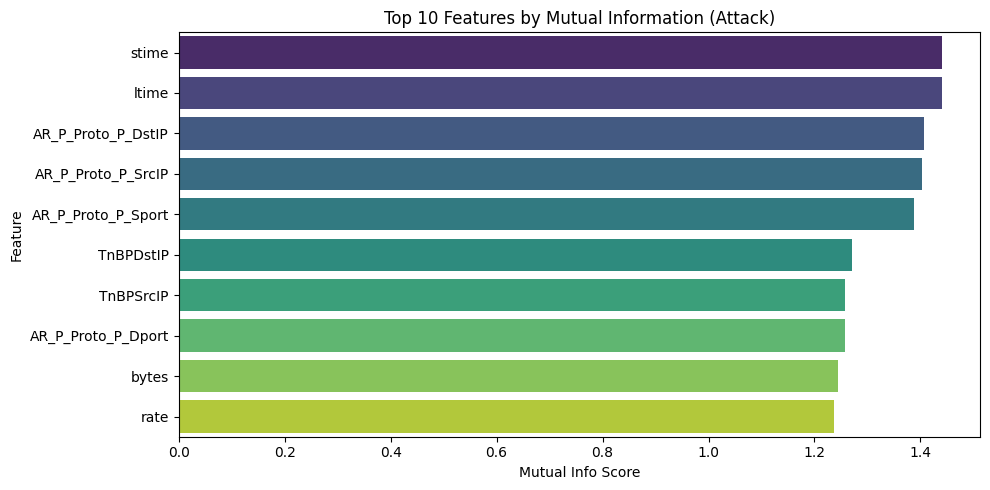

In [15]:
for target in targets:
    mi = mutual_info_classif(X_train, y_train[target], discrete_features=True)
    mi_scores = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)
    

    plt.figure(figsize=(10, 5))
    sns.barplot(x=mi_scores.values[:10], y=mi_scores.index[:10], palette="viridis")
    plt.title("Top 10 Features by Mutual Information (Attack)")
    plt.xlabel("Mutual Info Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


Chi Square test

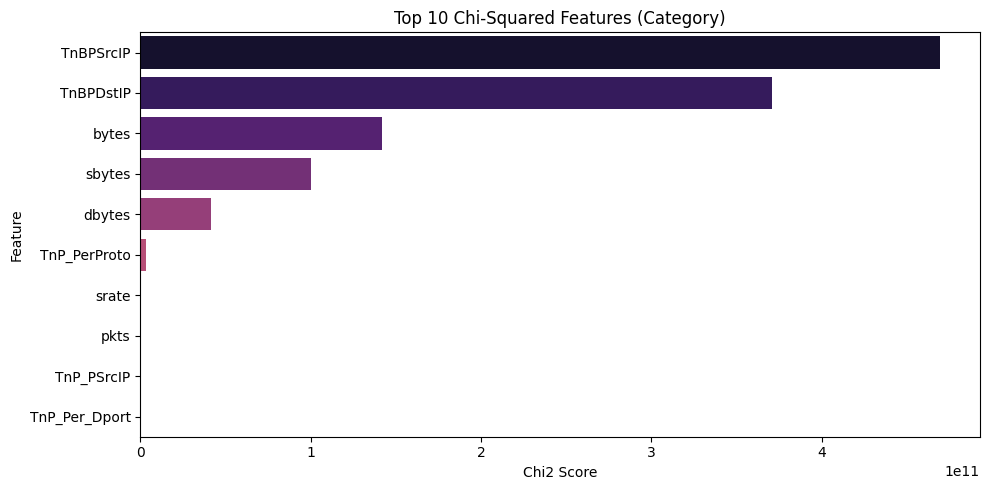

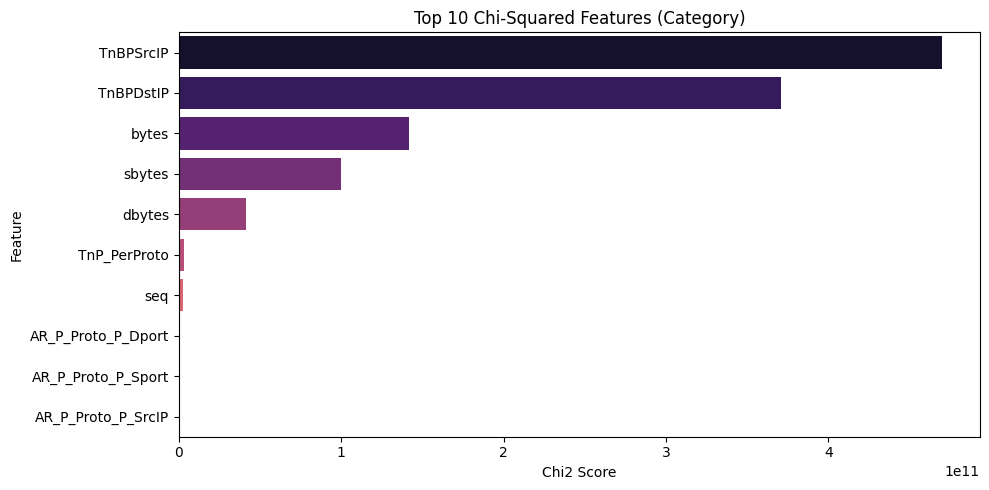

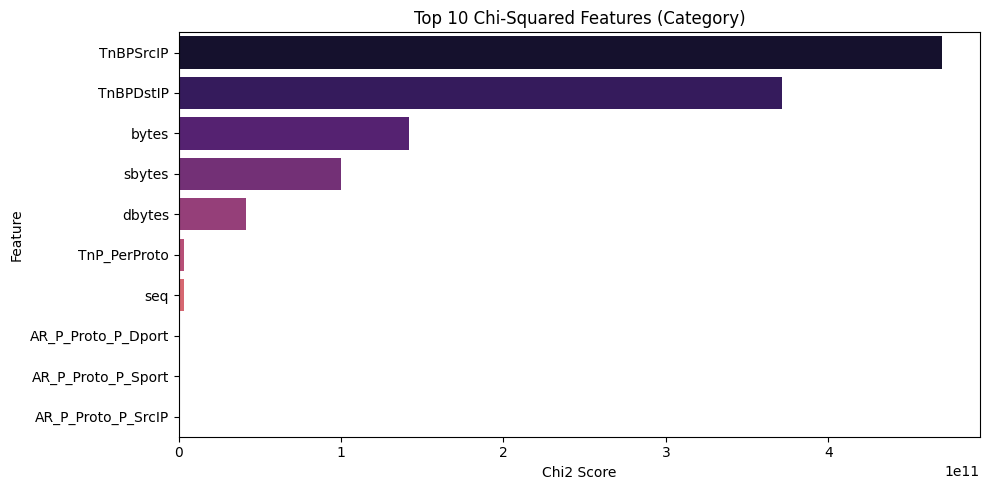

In [16]:
#b. Chi-Square Test


for target in targets:
    chi_selector = SelectKBest(score_func=chi2, k=10)
    chi_selector.fit(X_train, y_train[target])
    chi_scores = pd.Series(chi_selector.scores_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=chi_scores.values[:10], y=chi_scores.index[:10], palette="magma")
    plt.title("Top 10 Chi-Squared Features (Category)")
    plt.xlabel("Chi2 Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


WRAPPER METHODS

In [ ]:
#RFE
#

#for target in targets:
    #model = RandomForestClassifier(n_estimators=100, random_state=42)
    #rfe = RFE(model, n_features_to_select=10)
    #rfe.fit(X_train, y_train[target])
    #selected = X_train.columns[rfe.support_]
    #print(f"\n RFE Selected Features for '{target}':")
    #print(selected.tolist())


EMBEDED METHODS

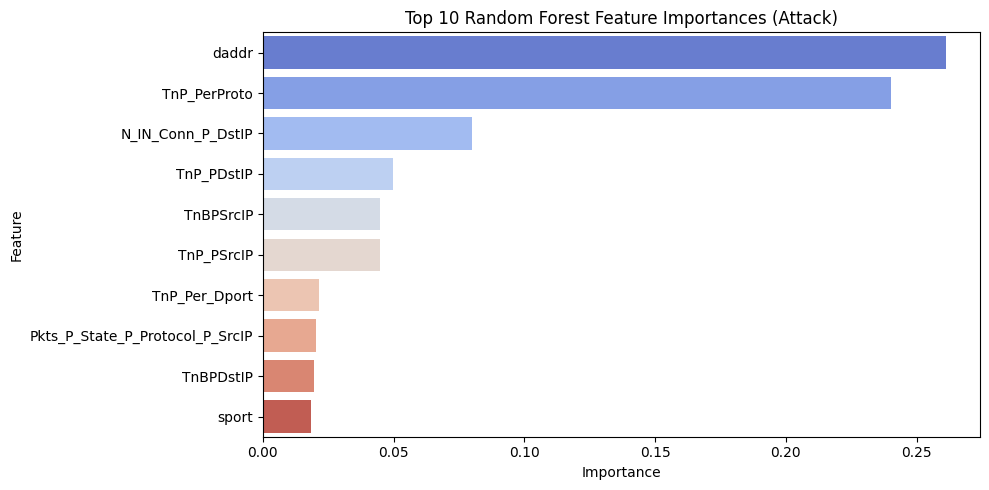

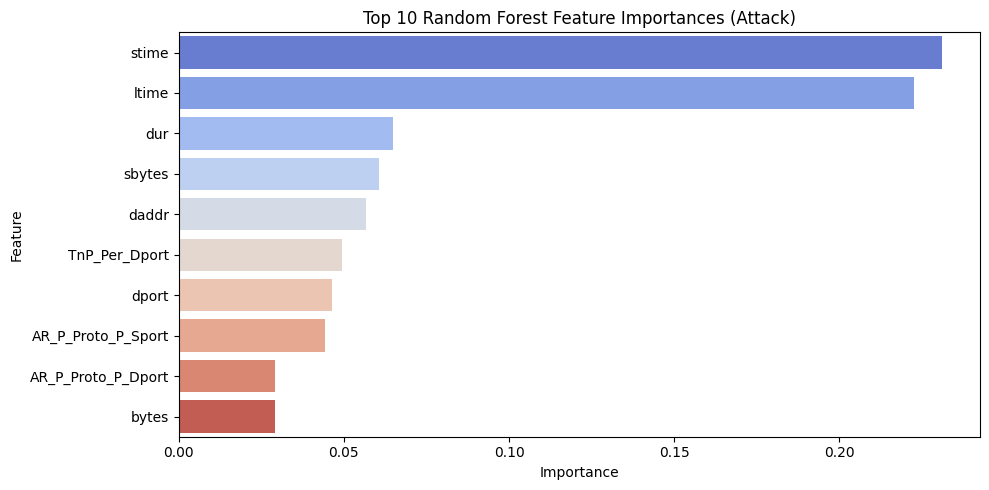

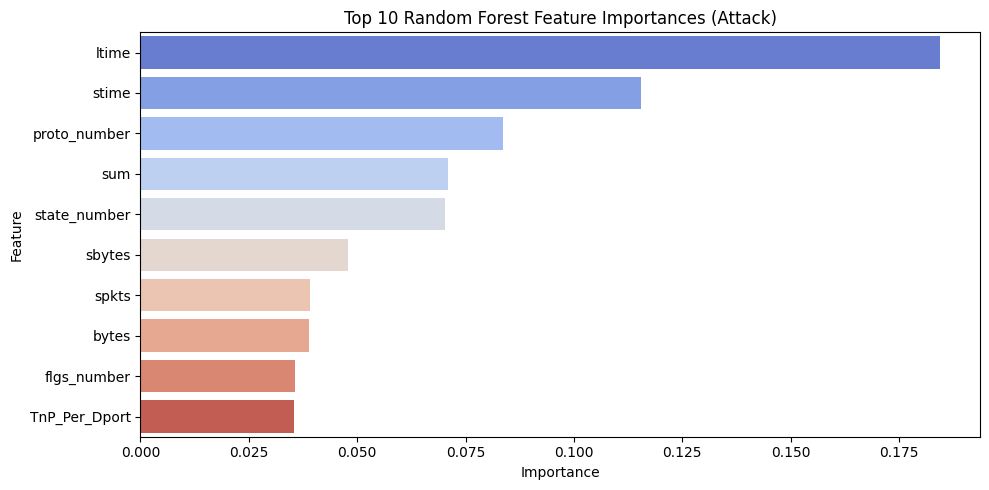

In [ ]:
#andom Forest Importances
for target in targets:
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train[target])
    importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=importances.values[:10], y=importances.index[:10], palette="coolwarm")
    plt.title("Top 10 Random Forest Feature Importances (Attack)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    


In [ ]:
# L1 Regularization (Lasso)
#

#for target in targets:
    #model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
    #model.fit(X_train, y_train[target])
    #l1_support = np.abs(model.coef_)[0] > 1e-5
    ##selected = X_train.columns[l1_support]
    #print(f"\n L1 (Lasso) Selected Features for '{target}':")
    #print(selected.tolist())


combining the features selected by all the methods so that there is a average

In [17]:


# Replace these with your actual feature lists for each method and each target
# Format: method_target = [list_of_features]

# Example: mutual_info for attack, category, subcategory
mi_attack = ['stime','ltime','TnBPSrcIP','TnBPDstIP','AR_P_Proto_P_SrcIP','TnP_PerProto', 'AR_P_Proto_P_DstIP','AR_P_Proto_P_Dport','AR_P_Proto_P_Sport' , 'daddr']
mi_category = ['stime', 'ltime', 'AR_P_Proto_P_DstIP''ltime','AR_P_Proto_P_SrcIP','AR_P_Proto_P_Sport', 'TnBPDstIP', 'TnBPSrcIP','AR_P_Proto_P_Dport','bytes','rate']
mi_subcategory =['stime','ltime','AR_P_Proto_P_DstIP','AR_P_Proto_P_SrcIP','AR_P_Proto_P_Sport','TnBPDstIP','TnBPSrcIP','AR_P_Proto_P_Dport','bytes','rate']

chi2_attack = ['TnBPSrcIP','TnBPDstIP','bytes', 'sbytes', 'dbytes','TnP_PerProto','srate','pkts','TnP_PSrcIP','TnP_Per_Dport']
chi2_category=['TnBPSrcIP','TnBPDstIP', 'bytes','sbytes', 'dbytes','TnP_PerProto','seq','AR_P_Proto_P_Dport', 'AR_P_Proto_P_Sport','AR_P_Proto_P_SrcIP']
chi2_subcategory=['TnBPSrcIP','TnBPDstIP','bytes','sbytes','dbytes','TnP_PerProto','seq', 'AR_P_Proto_P_Dport''AR_P_Proto_P_SrcIP']

rfe_attack = ['sport', 'daddr', 'dport', 'TnBPSrcIP', 'TnP_PSrcIP', 'TnP_PDstIP', 'TnP_PerProto', 'TnP_Per_Dport', 'N_IN_Conn_P_DstIP', 'Pkts_P_State_P_Protocol_P_SrcIP']
rfe_category = ['stime', 'daddr', 'dport', 'bytes', 'ltime', 'dur', 'sbytes', 'TnP_Per_Dport', 'AR_P_Proto_P_DstIP', 'N_IN_Conn_P_DstIP']
rfe_subcategory = ['stime', 'proto_number', 'bytes', 'state_number', 'ltime', 'sum', 'spkts', 'sbytes', 'dbytes', 'TnP_Per_Dport']


rf_attack = ['daddr','TnP_PerProto','N_IN_Conn_P_DstIP','TnP_PDstIP','TnBPSrcIP','TnP_PSrcIP','TnP_Per_Dport', 'Pkts_P_State_P_Protocol_P_SrcIP','TnBPDstIP','sport']
rf_category = ['stime','ltime','dur','sbytes','daddr','TnP_Per_Dport','dport','AR_P_Proto_P_Sport','AR_P_Proto_P_Dport','bytes']
rf_subcategory = ['ltim','stime','proto_number','sum','state_number','sbytes','spkts','bytes','flgs_number','TnP_Per_Dport']



# Combine all feature lists into one big list
all_features = (
    mi_attack + mi_category + mi_subcategory +
    chi2_attack + chi2_category + chi2_subcategory +
    rfe_attack + rfe_category + rfe_subcategory +
    rf_attack + rf_category + rf_subcategory
)

# Count frequency of each feature
feature_counts = Counter(all_features)

# Convert to DataFrame for sorting
feature_ranking_df = pd.DataFrame(feature_counts.items(), columns=['Feature', 'Count'])
feature_ranking_df = feature_ranking_df.sort_values(by='Count', ascending=False)

# Get top 20 features
top_20_features = feature_ranking_df.head(20)

# Show the top 20 features
print(" Top 20 Features across all methods and targets:\n")
print(top_20_features)


 Top 20 Features across all methods and targets:

               Feature  Count
11               bytes      9
2            TnBPSrcIP      8
0                stime      7
13              sbytes      7
3            TnBPDstIP      7
18       TnP_Per_Dport      7
1                ltime      6
5         TnP_PerProto      6
8   AR_P_Proto_P_Sport      5
9                daddr      5
7   AR_P_Proto_P_Dport      5
14              dbytes      4
4   AR_P_Proto_P_SrcIP      4
22               dport      3
24   N_IN_Conn_P_DstIP      3
17          TnP_PSrcIP      3
6   AR_P_Proto_P_DstIP      3
29                 sum      2
26                 dur      2
27        proto_number      2


Creating a new dataframe with only the selected features and the 3 target columns.

In [18]:
selected_features = ['bytes','TnBPSrcIP','stime','sbytes','TnBPDstIP' ,'TnP_Per_Dport','ltime','TnP_PerProto','AR_P_Proto_P_Sport','daddr' ,'AR_P_Proto_P_Dport','dbytes','AR_P_Proto_P_SrcIP','dport','N_IN_Conn_P_DstIP','TnP_PSrcIP','AR_P_Proto_P_DstIP','sum','dur','proto_number'   
]

# 3. Also keep the target columns
target_columns = ['attack', 'category', 'subcategory']

# 4. Keep only selected features + targets
final_df = df_encoded[selected_features + target_columns].copy()

# 5. (Optional) Print results
print(" Final dataset shape:", final_df.shape)
print(" Columns in final_df:", final_df.columns.tolist())


 Final dataset shape: (99951, 23)
 Columns in final_df: ['bytes', 'TnBPSrcIP', 'stime', 'sbytes', 'TnBPDstIP', 'TnP_Per_Dport', 'ltime', 'TnP_PerProto', 'AR_P_Proto_P_Sport', 'daddr', 'AR_P_Proto_P_Dport', 'dbytes', 'AR_P_Proto_P_SrcIP', 'dport', 'N_IN_Conn_P_DstIP', 'TnP_PSrcIP', 'AR_P_Proto_P_DstIP', 'sum', 'dur', 'proto_number', 'attack', 'category', 'subcategory']


caluculating the variance in the 20 featiures that were selected to choose wether standardization is needed or not.

<Figure size 1400x600 with 0 Axes>

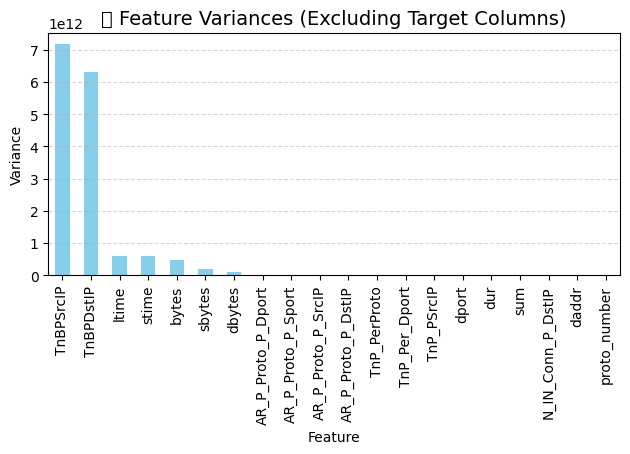

In [19]:

# Assuming your DataFrame is called df_filtered
target_columns = ['attack', 'category', 'subcategory']

# Select only the feature columns (exclude target columns)
feature_columns = [col for col in final_df.columns if col not in target_columns]
features_only = final_df[feature_columns]

# Calculate variance for each feature column
variances = features_only.var()

# Create a DataFrame for better viewing
variance_df = variances.sort_values(ascending=False).to_frame(name='Variance')


# 🔍 Visualization - Bar Plot
plt.figure(figsize=(14, 6))
variance_df.plot(kind='bar', legend=False, color='skyblue')
plt.title("🔍 Feature Variances (Excluding Target Columns)", fontsize=14)
plt.ylabel("Variance")
plt.xlabel("Feature")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


Since there is a high variance in two columns we will standardize them

In [20]:


# Columns to standardize
cols_to_standardize = ['TnBPDstIP', 'TnBPSrcIP']

# Create a copy of your DataFrame to avoid modifying the original
df_standardized = final_df.copy()

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
df_standardized[cols_to_standardize] = scaler.fit_transform(df_standardized[cols_to_standardize])
print(" Final dataset shape:", df_standardized.shape)
final_df=df_standardized
print(" Columns in final_df:", final_df.columns.tolist())

 Final dataset shape: (99951, 23)
 Columns in final_df: ['bytes', 'TnBPSrcIP', 'stime', 'sbytes', 'TnBPDstIP', 'TnP_Per_Dport', 'ltime', 'TnP_PerProto', 'AR_P_Proto_P_Sport', 'daddr', 'AR_P_Proto_P_Dport', 'dbytes', 'AR_P_Proto_P_SrcIP', 'dport', 'N_IN_Conn_P_DstIP', 'TnP_PSrcIP', 'AR_P_Proto_P_DstIP', 'sum', 'dur', 'proto_number', 'attack', 'category', 'subcategory']


This is the dristribution of the data points (classes) in the subcategory column


 Frequency of values in 'subcategory' column:
subcategory
4    30000
5    30000
3    25000
2    12000
0     2474
1      477
Name: count, dtype: int64


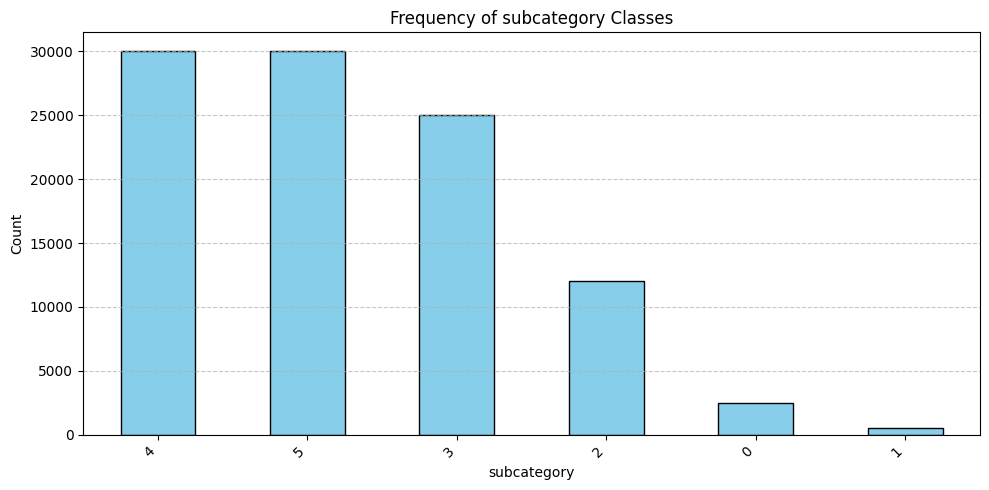

In [21]:
freq = final_df['subcategory'].value_counts()

print(f"\n Frequency of values in 'subcategory' column:")
print(freq)

# Plotting histogram/bar chart
plt.figure(figsize=(10, 5))
freq.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"Frequency of subcategory Classes")
plt.xlabel(f"subcategory")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now we will perform SMOTE(Synthetic Minority Oversampling Technique) to balance the dataset by generating synthetic samples.

In [22]:



# Separate features and target
X = final_df.drop(columns=['subcategory'])
y = final_df['subcategory']

# Check original class distribution
print("Original class distribution:", Counter(y))

# Determine current counts
class_counts = Counter(y)

# Define custom desired counts (based on your oversampling needs)
# For example, multiply class 0 and 1 by 3x, class 2 by 1.5x
sampling_strategy = {
    0: int(class_counts[0] * 9),
    1: int(class_counts[1] * 35),
    2: int(class_counts[2] * 1.75),
    # Leave class 3 and 4 unchanged (not included in strategy)
}

# Apply SMOTE with the custom sampling strategy
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine into a new DataFrame
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df['subcategory'] = y_resampled

# Show new distribution
print("New class distribution:", Counter(y_resampled))
print("Size:",resampled_df.shape)


Original class distribution: Counter({4: 30000, 5: 30000, 3: 25000, 2: 12000, 0: 2474, 1: 477})
New class distribution: Counter({4: 30000, 5: 30000, 3: 25000, 0: 22266, 2: 21000, 1: 16695})
Size: (144961, 23)


visualization of the newely sampled data.


 Frequency of values in 'subcategory' column:
subcategory
4    30000
5    30000
3    25000
0    22266
2    21000
1    16695
Name: count, dtype: int64


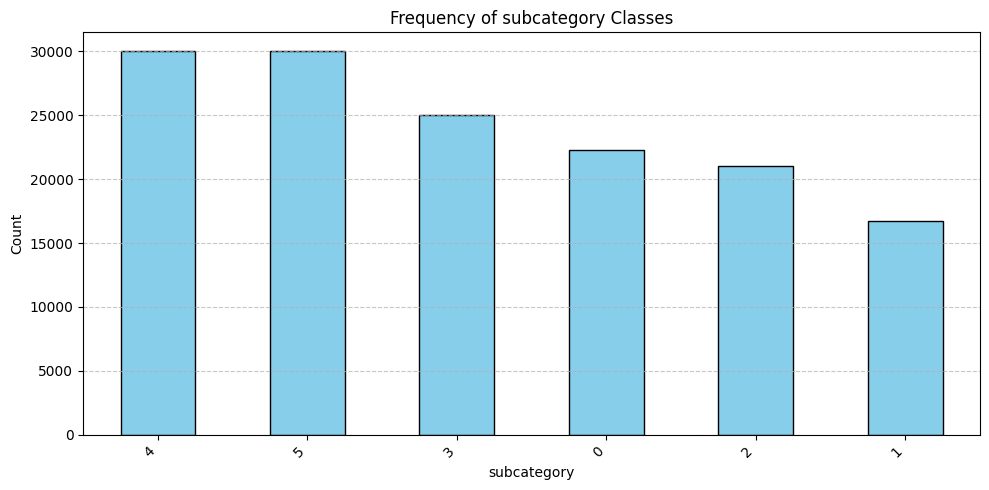

In [23]:
freq = resampled_df['subcategory'].value_counts()

print(f"\n Frequency of values in 'subcategory' column:")
print(freq)

# Plotting histogram/bar chart
plt.figure(figsize=(10, 5))
freq.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"Frequency of subcategory Classes")
plt.xlabel(f"subcategory")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Now the dataset is cleaned properly balanced anf inportant features are selected making it suatible to be fed to the classifiers for model training.

In [24]:


target_columns = ['attack', 'category', 'subcategory']  # Multiple targets

# ==== Feature and Target split ====
X = resampled_df.drop(columns=target_columns)
y = resampled_df[target_columns]

# ==== Train-Test Split (no stratify for multi-output) ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==== Optional Print ====
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")
print(f"Target columns: {target_columns}")

Training set: (115968, 20), Testing set: (28993, 20)
Target columns: ['attack', 'category', 'subcategory']


CLASSIFIERS

Randomforest classifier.

In [25]:


# Fit the Random Forest Model with MultiOutputClassifier
rf_model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Print classification reports for each output/target column
print(" Random Forest Classification Reports:")
for i, col in enumerate(y_test.columns):
    print(f"\n Report for '{col}':")
    # Using 'i' to index both y_test and y_pred_rf to match the correct columns
    print(classification_report(y_test.iloc[:, i], y_pred_rf[:, i]))


 Random Forest Classification Reports:

📘 Report for 'attack':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3408
           1       1.00      1.00      1.00     25585

    accuracy                           1.00     28993
   macro avg       1.00      1.00      1.00     28993
weighted avg       1.00      1.00      1.00     28993


📘 Report for 'category':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8192
           1       1.00      1.00      1.00      8264
           2       1.00      1.00      1.00      3408
           3       1.00      1.00      1.00      9129

    accuracy                           1.00     28993
   macro avg       1.00      1.00      1.00     28993
weighted avg       1.00      1.00      1.00     28993


📘 Report for 'subcategory':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4449
           

K Nearest Neighbour classifier

In [26]:


knn_model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=5))
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)
print(" KNN Report:")
for i, col in enumerate(y_test.columns):
    print(f"\n📘 Report for '{col}':")
    # Using 'i' to index both y_test and y_pred_rf to match the correct columns
    print(classification_report(y_test.iloc[:, i], y_pred_knn[:, i]))


 KNN Report:

📘 Report for 'attack':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3408
           1       1.00      1.00      1.00     25585

    accuracy                           1.00     28993
   macro avg       1.00      1.00      1.00     28993
weighted avg       1.00      1.00      1.00     28993


📘 Report for 'category':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8192
           1       1.00      1.00      1.00      8264
           2       1.00      1.00      1.00      3408
           3       1.00      1.00      1.00      9129

    accuracy                           1.00     28993
   macro avg       1.00      1.00      1.00     28993
weighted avg       1.00      1.00      1.00     28993


📘 Report for 'subcategory':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4449
           1       1.00      1.00    

ENSEMBLE LEARNING

Gradient BOOSTING

In [ ]:
#Ensemble Learning – Gradient Boosting (HistGradientBoosting)


gb_model = MultiOutputClassifier(HistGradientBoostingClassifier())
gb_model.fit(X_train, y_train)

y_pred_gb = gb_model.predict(X_test)
print(" Gradient Boosting (HistGradient) Report:")
for i, col in enumerate(y_test.columns):
    print(f"\n📘 Report for '{col}':")
    # Using 'i' to index both y_test and y_pred_rf to match the correct columns
    print(classification_report(y_test.iloc[:, i], y_pred_gb[:, i]))


🎯 Gradient Boosting (HistGradient) Report:

📘 Report for 'attack':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3408
           1       1.00      1.00      1.00     25585

    accuracy                           1.00     28993
   macro avg       1.00      1.00      1.00     28993
weighted avg       1.00      1.00      1.00     28993


📘 Report for 'category':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8192
           1       1.00      1.00      1.00      8264
           2       1.00      1.00      1.00      3408
           3       1.00      1.00      1.00      9129

    accuracy                           1.00     28993
   macro avg       1.00      1.00      1.00     28993
weighted avg       1.00      1.00      1.00     28993


📘 Report for 'subcategory':
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4449
       

Doing an comparitive study on the results generated by the three algoeithms.

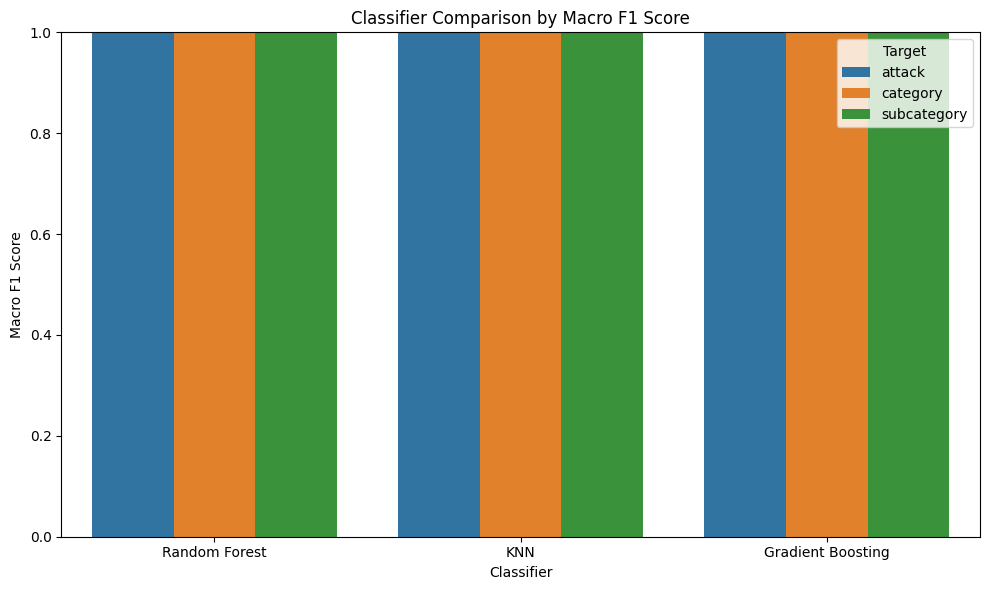

In [ ]:


# Assumes y_test has columns: ['attack', 'category', 'subcategory']
targets = y_test.columns.tolist()
classifiers = {
    'Random Forest': y_pred_rf,
    'KNN': y_pred_knn,
    'Gradient Boosting': y_pred_gb
}

# Calculate macro F1 scores
results = {'Classifier': []}
for target in targets:
    results[target] = []

for clf_name, preds in classifiers.items():
    results['Classifier'].append(clf_name)
    for i, target in enumerate(targets):
        score = f1_score(y_test.iloc[:, i], preds[:, i], average='macro')
        results[target].append(score)

# Convert to DataFrame
df_scores = pd.DataFrame(results)

# Melt and visualize
df_melted = df_scores.melt(id_vars='Classifier', var_name='Target', value_name='Macro F1 Score')

plt.figure(figsize=(10, 6))
sns.barplot(data=df_melted, x='Classifier', y='Macro F1 Score', hue='Target')
plt.title("Classifier Comparison by Macro F1 Score")
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()
